In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [2]:
# FRED Data Loader Function
def load_fred_csv(path):
    df = pd.read_csv(path)
    # Set date
    df['date'] = pd.to_datetime(df['observation_date'])
    df = df.set_index('date')
    df = df.drop('observation_date', axis=1)
    return df

# Load FRED Price Data
beef = load_fred_csv("../data/PBEEFUSDM.csv")
corn = load_fred_csv("../data/PMAIZMTUSDM.csv")
pork = load_fred_csv("../data/PPORKUSDM.csv")
lamb = load_fred_csv("../data/PLAMBUSDM.csv")
chicken = load_fred_csv("../data/PPOULTUSDM.csv")
oil = load_fred_csv("../data/POILBREUSDM.csv")
usd = load_fred_csv("../data/RTWEXBGS_PCH.csv")

# US Drought Data
us_drought = pd.read_csv("../data/us_drought.csv")
date_col = "Month"
us_drought[date_col] = pd.to_datetime(us_drought[date_col])
us_drought = us_drought.set_index(date_col)
us_drought.index = us_drought.index.to_period("M").to_timestamp(how="start")
us_drought = us_drought.sort_index()
us_drought = us_drought[~us_drought.index.duplicated(keep="first")]

# Remove 'None' column and rename D0-D4 to include USA suffix
drought_columns = ['D0', 'D1', 'D2', 'D3', 'D4']
if 'None' in us_drought.columns:
    us_drought = us_drought.drop(columns=['None'])
us_drought[drought_columns] = us_drought[drought_columns].fillna(0)
us_drought = us_drought.rename(columns={
    'D0': 'D0_USA',
    'D1': 'D1_USA',
    'D2': 'D2_USA',
    'D3': 'D3_USA',
    'D4': 'D4_USA'
})

# Brazil Drought Data
brazil_drought = pd.read_csv("../data/brazil_drought.csv")
brazil_drought["date"] = pd.to_datetime(brazil_drought["date"])
brazil_drought = brazil_drought.set_index("date")

# Rename Brazil drought columns and drop cwd_BR
if 'cdd' in brazil_drought.columns:
    brazil_drought = brazil_drought.rename(columns={'cdd': 'cdd_BR'})
if 'pr' in brazil_drought.columns:
    brazil_drought = brazil_drought.rename(columns={'pr': 'precip_BR'})
if 'cwd' in brazil_drought.columns:
    brazil_drought = brazil_drought.drop(columns=['cwd'])

# ENSO Data
enso = pd.read_csv("../data/ncep_noaa_seatemp.txt",
                   sep='\\s+',
                   names=["YR","MON","TOTAL","ClimAdjust","ANOM"],
                   comment="#",
                   skiprows=1)
enso['date'] = pd.to_datetime(dict(year=enso.YR, month=enso.MON, day=1))
enso = enso.set_index('date')
enso = enso[['ANOM']].rename(columns={'ANOM': 'enso_anomaly'})

In [3]:
# FAO Food Price Index - Load from CSV
food_index = pd.read_csv("../data/food_price_index.csv", sep=';')
# Keep only the first two columns (Date and Food Price Index) and drop the rest
food_index = food_index.iloc[:, :2]
food_index.columns = ['date', 'fao_food_index']
food_index['date'] = pd.to_datetime(food_index['date'], format='%Y-%m', errors='coerce')
food_index = food_index.dropna(subset=['date'])
food_index = food_index.set_index('date')
food_index.index = food_index.index.to_period("M").to_timestamp(how="start")
food_index = food_index[~food_index.index.duplicated(keep="first")]

In [4]:
# Bioethanol Production #
bioethanol = pd.read_csv("../data/bioethanolproduction.csv", sep=';', skipinitialspace=True)
bioethanol.columns = bioethanol.columns.str.strip()
# Parse date and value columns properly
date_col = bioethanol.columns[0]
value_col = bioethanol.columns[1]
bioethanol['date'] = pd.to_datetime(bioethanol[date_col], format='%b-%Y', errors='coerce')
bioethanol[value_col] = pd.to_numeric(bioethanol[value_col], errors='coerce')
# Rename the long column name to something shorter for easier reference
bioethanol = bioethanol[[value_col, 'date']].rename(columns={value_col: 'bioethanol_production'})
bioethanol = bioethanol.set_index('date')
bioethanol = bioethanol[~bioethanol.index.duplicated(keep='first')]

In [5]:
# China Retail Sales (divide by 1 million to scale down)
china_retail = pd.read_csv("../data/china_retail_sales_nominal.csv")
china_retail['Date'] = pd.to_datetime(china_retail['Date'], errors='coerce')
china_retail['Retail_Sales_nominal'] = pd.to_numeric(china_retail['Retail_Sales_nominal'], errors='coerce')
# Scale down by dividing by 1 million
china_retail['retail_china'] = china_retail['Retail_Sales_nominal'] / 1_000_000
china_retail = china_retail[['Date', 'retail_china']].rename(columns={'Date': 'date'})
china_retail = china_retail.set_index('date')
china_retail = china_retail[~china_retail.index.duplicated(keep='first')]

# USA Food & Beverage Retail Sales
fnb_retail = pd.read_csv("../data/retail_sales.csv")
fnb_retail['observation_date'] = pd.to_datetime(fnb_retail['observation_date'], errors='coerce')
fnb_retail['retail_sale_food_service_drinking_place'] = pd.to_numeric(fnb_retail['retail_sale_food_service_drinking_place'], errors='coerce')
fnb_retail = fnb_retail[['observation_date', 'retail_sale_food_service_drinking_place']].rename(
    columns={'observation_date': 'date', 'retail_sale_food_service_drinking_place': 'fnbretail_USA'}
)
fnb_retail = fnb_retail.set_index('date')
fnb_retail = fnb_retail[~fnb_retail.index.duplicated(keep='first')]

In [6]:
df = (corn
      .join(beef, how="outer")
      .join(pork, how="outer")
      .join(lamb, how="outer")
      .join(chicken, how="outer")
      .join(oil, how="outer")
      #.join(usd, how="outer") 
      .join(food_index, how="outer")
      .join(bioethanol, how="outer")
      .join(china_retail, how="outer")
      .join(fnb_retail, how="outer")
      .join(us_drought, how="outer")
      .join(brazil_drought, how="outer")
      .join(enso, how="outer")
     )

In [7]:
# Sort by date and clean the data
df = df.sort_index()

# Drop rows with any NaN values
df = df.dropna()

# Find the longest continuous segment (consecutive months without gaps)
# Convert index to periods to detect month-to-month continuity
index_as_periods = df.index.to_period('M')

# Calculate the difference in months between consecutive periods
diff_in_months_series = pd.Series(index_as_periods).diff().apply(lambda x: x.n if pd.notna(x) else 0).values

# Identify segments (where difference != 1, there's a gap)
segments = (diff_in_months_series != 1).cumsum()

# Find the longest segment
unique, counts = np.unique(segments, return_counts=True)
longest_segment = unique[np.argmax(counts)]

# Filter to longest segment
df_clean = df[segments == longest_segment].copy()

print(f"Original joined df shape: {df.shape}")
print(f"After removing NaN values: {df.shape}")
print(f"Longest continuous segment shape: {df_clean.shape}")
print(f"Date range of df_clean: {df_clean.index[0]} to {df_clean.index[-1]}")
print(f"Columns in df_clean: {list(df_clean.columns)}")

Original joined df shape: (242, 18)
After removing NaN values: (242, 18)
Longest continuous segment shape: (242, 18)
Date range of df_clean: 2002-11-01 00:00:00 to 2022-12-01 00:00:00
Columns in df_clean: ['PMAIZMTUSDM', 'PBEEFUSDM', 'PPORKUSDM', 'PLAMBUSDM', 'PPOULTUSDM', 'POILBREUSDM', 'fao_food_index', 'bioethanol_production', 'retail_china', 'fnbretail_USA', 'D0_USA', 'D1_USA', 'D2_USA', 'D3_USA', 'D4_USA', 'cdd_BR', 'precip_BR', 'enso_anomaly']


## EDA & Pre-processing

Summary Statistics for df_clean:


,PMAIZMTUSDM,PBEEFUSDM,PPORKUSDM,PLAMBUSDM,PPOULTUSDM,POILBREUSDM,fao_food_index,bioethanol_production,retail_china,fnbretail_USA,D0_USA,D1_USA,D2_USA,D3_USA,D4_USA,cdd_BR,precip_BR,enso_anomaly
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,2.420000e+02,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,188.316069,168.389331,72.104522,134.927993,101.695594,71.249873,99.988843,751.706612,1.933260e+06,46494.847107,17.014174,10.885000,8.215785,4.889793,1.705785,10.222603,147.000702,-0.085537
std,67.223973,48.349486,16.821360,26.345812,29.969954,27.102952,23.752042,304.287701,1.163976e+06,13859.686901,4.975288,3.816214,4.850147,4.026209,2.160655,5.984585,73.263905,0.833040
min,93.415148,78.250000,40.602105,86.119095,61.488636,24.250476,55.900000,166.000000,3.535200e+05,27058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.380000,33.160000,-1.690000
25%,150.702291,119.700000,58.957083,110.918264,80.799513,50.412490,86.775000,487.500000,8.127900e+05,36514.500000,13.440000,8.155000,4.472500,1.277500,0.060000,4.782500,71.082500,-0.700000
50%,166.708197,180.114130,69.867857,140.139116,94.610795,66.560227,96.950000,891.000000,1.834750e+06,42928.000000,17.505000,11.005000,7.440000,4.300000,0.960000,8.310000,149.900000,-0.175000
75%,235.567209,195.421690,81.280574,155.711640,114.214109,93.471769,120.775000,994.500000,3.019950e+06,56118.250000,20.900000,13.365000,11.265000,7.942500,2.447500,15.535000,212.805000,0.447500
max,348.507117,275.304348,128.667727,186.588721,227.963324,133.585217,160.200000,1089.000000,4.126900e+06,83665.000000,29.690000,22.080000,22.270000,16.100000,9.970000,23.340000,288.100000,2.710000



Visualizing US Drought Severities:


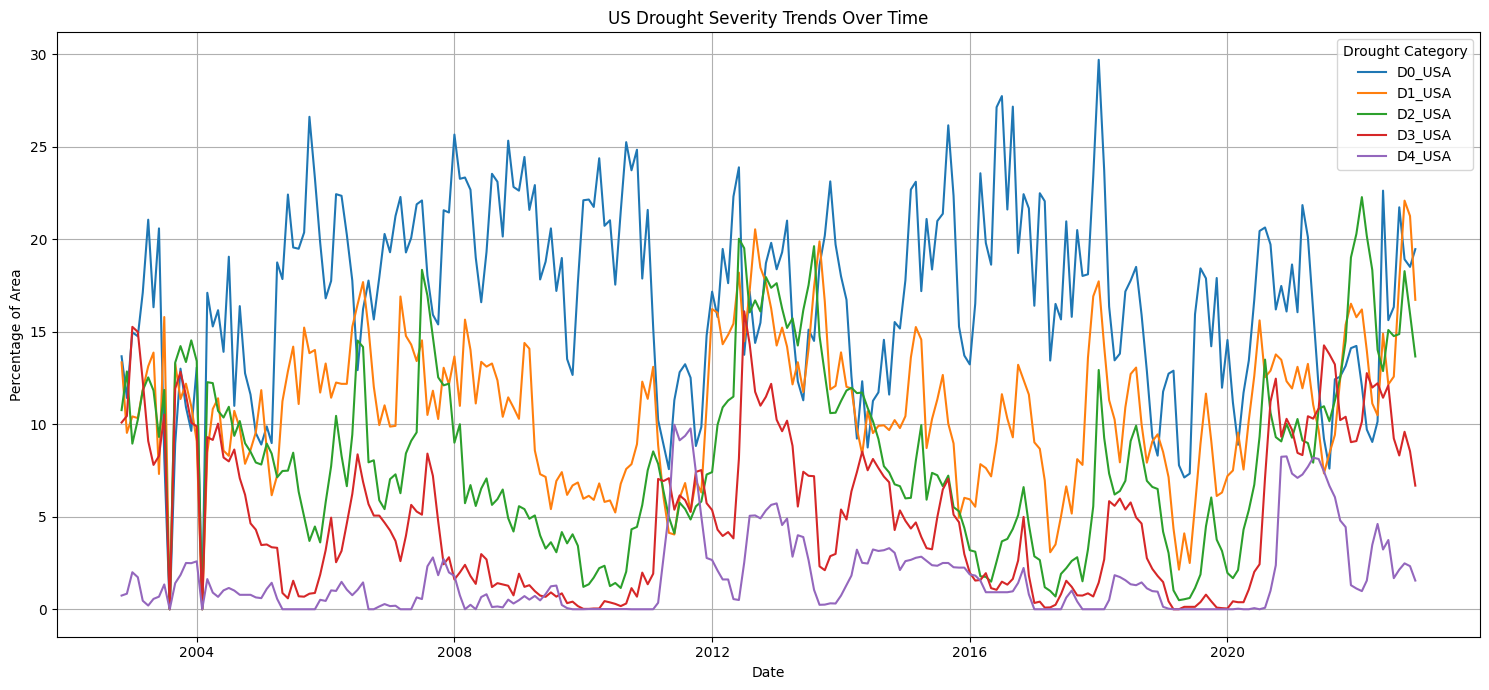

In [8]:
print("Summary Statistics for df_clean:")
display(df_clean.describe())

print("\nVisualizing US Drought Severities:")
drought_cols = ['D0_USA', 'D1_USA', 'D2_USA', 'D3_USA', 'D4_USA']

plt.figure(figsize=(15, 7))
for col in drought_cols:
    plt.plot(df_clean.index, df_clean[col], label=col)

plt.title('US Drought Severity Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Area')
plt.legend(title='Drought Category')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# ADF Test for stationarity of all variables #
# Test ALL variables in the dataset, not just prices
all_variables = df_clean.columns.tolist()
print(f"Variables to test: {all_variables}")

Variables to test: ['PMAIZMTUSDM', 'PBEEFUSDM', 'PPORKUSDM', 'PLAMBUSDM', 'PPOULTUSDM', 'POILBREUSDM', 'fao_food_index', 'bioethanol_production', 'retail_china', 'fnbretail_USA', 'D0_USA', 'D1_USA', 'D2_USA', 'D3_USA', 'D4_USA', 'cdd_BR', 'precip_BR', 'enso_anomaly']


In [10]:
def run_adf_test(series, variable_name):
    """Perform ADF test on a series and return results"""
    if series.isnull().any():
        series = series.dropna()
    
    if len(series) < 5:
        print(f"Warning: {variable_name} has too few observations ({len(series)}) for ADF test. Skipping.")
        return None
    
    try:
        adf_result = adfuller(series, autolag='AIC')
        return {
            'adf_statistic': adf_result[0],
            'p_value': adf_result[1],
            'critical_values': adf_result[4]
        }
    except Exception as e:
        print(f"Error testing {variable_name}: {e}")
        return None

# Perform ADF test on all variables
print(f"\n{'='*70}")
print(f"ADF Stationarity Test Results for All Variables")
print(f"{'='*70}\n")

for variable in all_variables:
    series = df_clean[variable].astype(float)
    result = run_adf_test(series, variable)
    
    if result:
        stationary = "YES" if result['p_value'] <= 0.05 else "NO"
        print(f"{variable:25} | ADF Stat: {result['adf_statistic']:8.4f} | p-value: {result['p_value']:.6f} | Stationary: {stationary}")


ADF Stationarity Test Results for All Variables

PMAIZMTUSDM               | ADF Stat:  -1.8987 | p-value: 0.332657 | Stationary: NO
PBEEFUSDM                 | ADF Stat:  -1.8219 | p-value: 0.369656 | Stationary: NO
PPORKUSDM                 | ADF Stat:  -4.5673 | p-value: 0.000148 | Stationary: YES
PLAMBUSDM                 | ADF Stat:  -2.4664 | p-value: 0.123867 | Stationary: NO
PPOULTUSDM                | ADF Stat:  -0.7545 | p-value: 0.832120 | Stationary: NO
POILBREUSDM               | ADF Stat:  -2.8936 | p-value: 0.046100 | Stationary: YES
fao_food_index            | ADF Stat:  -2.1282 | p-value: 0.233322 | Stationary: NO
bioethanol_production     | ADF Stat:  -2.1265 | p-value: 0.234011 | Stationary: NO
retail_china              | ADF Stat:  -0.0333 | p-value: 0.955693 | Stationary: NO
fnbretail_USA             | ADF Stat:   1.0146 | p-value: 0.994418 | Stationary: NO
D0_USA                    | ADF Stat:  -6.7562 | p-value: 0.000000 | Stationary: YES
D1_USA                 

In [11]:
# Create comprehensive ADF summary table for all variables
adf_summary = []

for variable in all_variables:
    series = df_clean[variable].astype(float)
    
    if series.isnull().any():
        series = series.dropna()
    
    if len(series) < 5:
        continue
    
    try:
        adf_result = adfuller(series, autolag='AIC')
        adf_statistic = adf_result[0]
        p_value = adf_result[1]
        critical_1pct = adf_result[4]['1%']
        critical_5pct = adf_result[4]['5%']
        critical_10pct = adf_result[4]['10%']
        stationary = 'Stationary' if p_value <= 0.05 else 'Non-stationary'
        
        adf_summary.append({
            'Variable': variable,
            'ADF Statistic': round(adf_statistic, 4),
            'P-value': round(p_value, 6),
            'Critical 1%': round(critical_1pct, 4),
            'Critical 5%': round(critical_5pct, 4),
            'Critical 10%': round(critical_10pct, 4),
            'Stationary': stationary
        })
    except Exception as e:
        print(f"Error for {variable}: {e}")

# Create and display summary DataFrame
adf_summary_df = pd.DataFrame(adf_summary)
print("\n" + "="*100)
print("ADF STATIONARITY TEST SUMMARY")
print("="*100)
display(adf_summary_df)


ADF STATIONARITY TEST SUMMARY


,Variable,ADF Statistic,P-value,Critical 1%,Critical 5%,Critical 10%,Stationary
0,PMAIZMTUSDM,-1.8987,0.332657,-3.4579,-2.8737,-2.5732,Non-stationary
1,PBEEFUSDM,-1.8219,0.369656,-3.4582,-2.8738,-2.5733,Non-stationary
2,PPORKUSDM,-4.5673,0.000148,-3.4579,-2.8737,-2.5732,Stationary
3,PLAMBUSDM,-2.4664,0.123867,-3.4581,-2.8738,-2.5733,Non-stationary
4,PPOULTUSDM,-0.7545,0.832120,-3.4596,-2.8744,-2.5736,Non-stationary
5,POILBREUSDM,-2.8936,0.046100,-3.4579,-2.8737,-2.5732,Stationary
6,fao_food_index,-2.1282,0.233322,-3.4579,-2.8737,-2.5732,Non-stationary
7,bioethanol_production,-2.1265,0.234011,-3.4594,-2.8743,-2.5736,Non-stationary
8,retail_china,-0.0333,0.955693,-3.4596,-2.8744,-2.5736,Non-stationary
9,fnbretail_USA,1.0146,0.994418,-3.4595,-2.8744,-2.5736,Non-stationary


## First Differencing (Log Returns)

Apply log first differencing to non-stationary price variables to achieve stationarity.

In [12]:
# Identify ALL non-stationary variables from ADF test
non_stationary_variables = adf_summary_df[adf_summary_df['Stationary'] == 'Non-stationary']['Variable'].tolist()

# Create df_firstdiff starting from df_clean
df_firstdiff = df_clean.copy()

print("\n" + "="*100)
print("APPLYING LOG FIRST DIFFERENCING TO ALL NON-STATIONARY VARIABLES")
print("="*100)
print(f"\nNon-stationary variables identified: {len(non_stationary_variables)}")
for var in non_stationary_variables:
    print(f"  - {var}")

# Apply log first differencing to all non-stationary variables
print("\n" + "-"*100)
for var in non_stationary_variables:
    if var in df_firstdiff.columns:
        # Calculate log returns: ln(P_t) - ln(P_t-1)
        df_firstdiff[var] = np.log(df_clean[var]).diff()
        print(f"✓ Applied log first differencing to: {var}")

# Drop the first row (NaN from differencing)
df_firstdiff = df_firstdiff.dropna()

print("\n" + "="*100)
print(f"Original df_clean shape: {df_clean.shape}")
print(f"After first differencing: {df_firstdiff.shape}")
print(f"Date range: {df_firstdiff.index.min()} to {df_firstdiff.index.max()}")
print(f"Rows lost: {df_clean.shape[0] - df_firstdiff.shape[0]}")


APPLYING LOG FIRST DIFFERENCING TO ALL NON-STATIONARY VARIABLES

Non-stationary variables identified: 8
  - PMAIZMTUSDM
  - PBEEFUSDM
  - PLAMBUSDM
  - PPOULTUSDM
  - fao_food_index
  - bioethanol_production
  - retail_china
  - fnbretail_USA

----------------------------------------------------------------------------------------------------
✓ Applied log first differencing to: PMAIZMTUSDM
✓ Applied log first differencing to: PBEEFUSDM
✓ Applied log first differencing to: PLAMBUSDM
✓ Applied log first differencing to: PPOULTUSDM
✓ Applied log first differencing to: fao_food_index
✓ Applied log first differencing to: bioethanol_production
✓ Applied log first differencing to: retail_china
✓ Applied log first differencing to: fnbretail_USA

Original df_clean shape: (242, 18)
After first differencing: (241, 18)
Date range: 2002-12-01 00:00:00 to 2022-12-01 00:00:00
Rows lost: 1


In [13]:
# Perform ADF test on df_firstdiff to verify stationarity
print("\n" + "="*100)
print("ADF TEST ON FIRST-DIFFERENCED DATA")
print("="*100)

adf_firstdiff_summary = []

for variable in df_firstdiff.columns:
    series = df_firstdiff[variable].astype(float).dropna()
    
    if len(series) < 5:
        continue
    
    try:
        adf_result = adfuller(series, autolag='AIC')
        adf_statistic = adf_result[0]
        p_value = adf_result[1]
        critical_1pct = adf_result[4]['1%']
        critical_5pct = adf_result[4]['5%']
        critical_10pct = adf_result[4]['10%']
        stationary = 'Stationary' if p_value <= 0.05 else 'Non-stationary'
        
        adf_firstdiff_summary.append({
            'Variable': variable,
            'ADF Statistic': round(adf_statistic, 4),
            'P-value': round(p_value, 6),
            'Critical 1%': round(critical_1pct, 4),
            'Critical 5%': round(critical_5pct, 4),
            'Critical 10%': round(critical_10pct, 4),
            'Stationary': stationary
        })
    except Exception as e:
        print(f"Error for {variable}: {e}")

# Create and display summary DataFrame
adf_firstdiff_df = pd.DataFrame(adf_firstdiff_summary)
print("\n" + "="*100)
print("ADF TEST RESULTS FOR FIRST-DIFFERENCED DATA")
print("="*100)
display(adf_firstdiff_df)

# Count stationary variables
stationary_count = (adf_firstdiff_df['Stationary'] == 'Stationary').sum()
total_count = len(adf_firstdiff_df)
print(f"\n✓ All {stationary_count}/{total_count} variables are now stationary")


ADF TEST ON FIRST-DIFFERENCED DATA

ADF TEST RESULTS FOR FIRST-DIFFERENCED DATA

ADF TEST RESULTS FOR FIRST-DIFFERENCED DATA


,Variable,ADF Statistic,P-value,Critical 1%,Critical 5%,Critical 10%,Stationary
0,PMAIZMTUSDM,-3.0386,0.031445,-3.4598,-2.8745,-2.5737,Stationary
1,PBEEFUSDM,-8.3003,0.000000,-3.4584,-2.8739,-2.5733,Stationary
2,PPORKUSDM,-4.5525,0.000158,-3.4580,-2.8737,-2.5733,Stationary
3,PLAMBUSDM,-5.5081,0.000002,-3.4581,-2.8738,-2.5733,Stationary
4,PPOULTUSDM,-3.8503,0.002433,-3.4598,-2.8745,-2.5737,Stationary
5,POILBREUSDM,-2.8886,0.046688,-3.4580,-2.8737,-2.5733,Stationary
6,fao_food_index,-8.3179,0.000000,-3.4579,-2.8737,-2.5732,Stationary
7,bioethanol_production,-2.9525,0.039579,-3.4592,-2.8742,-2.5735,Stationary
8,retail_china,-3.9135,0.001938,-3.4592,-2.8742,-2.5735,Stationary
9,fnbretail_USA,-9.3634,0.000000,-3.4585,-2.8739,-2.5734,Stationary



✓ All 18/18 variables are now stationary


In [14]:
# Export df_firstdiff to CSV
print("\n" + "="*100)
print("EXPORTING FIRST-DIFFERENCED DATA TO CSV")
print("="*100)

firstdiff_csv_path = "../data/df_firstdiff.csv"
df_firstdiff_export = df_firstdiff.reset_index()
df_firstdiff_export.rename(columns={'date': 'month'}, inplace=True)
df_firstdiff_export.to_csv(firstdiff_csv_path, index=False)

print(f"\n✓ df_firstdiff exported to: {firstdiff_csv_path}")
print(f"  Shape: {df_firstdiff.shape}")
print(f"  Date range: {df_firstdiff.index.min()} to {df_firstdiff.index.max()}")
print(f"  All variables are stationary (log first-differenced)")

print("\n" + "="*100)
print("First differencing export complete!")
print("="*100)


EXPORTING FIRST-DIFFERENCED DATA TO CSV

✓ df_firstdiff exported to: ../data/df_firstdiff.csv
  Shape: (241, 18)
  Date range: 2002-12-01 00:00:00 to 2022-12-01 00:00:00
  All variables are stationary (log first-differenced)

First differencing export complete!


In [ ]:
print("\n" + "="*100)
print("FINAL DATA SUMMARY")
print("="*100)

print("\n1. ORIGINAL DATA (df_clean.csv):")
print(f"   Shape: {df_clean.shape}")
print(f"   Date range: {df_clean.index.min()} to {df_clean.index.max()}")
print(f"   Variables: {', '.join(df_clean.columns.tolist())}")

print("\n2. FIRST-DIFFERENCED DATA (df_firstdiff.csv):")
print(f"   Shape: {df_firstdiff.shape}")
print(f"   Date range: {df_firstdiff.index.min()} to {df_firstdiff.index.max()}")
print(f"   Variables transformed: {', '.join(non_stationary_variables)}")

print("\n" + "="*100)
print("DATA CLEANING COMPLETE")
print("="*100)

# Export df_clean
clean_csv_path = "../data/df_clean.csv"
df_clean_export = df_clean.reset_index()
df_clean_export.rename(columns={'date': 'month'}, inplace=True)
df_clean_export.to_csv(clean_csv_path, index=False)

print(f"\nDatasets saved to /data folder:")
print(f"  ✓ {clean_csv_path}")
print(f"  ✓ {firstdiff_csv_path}")